<a href="https://colab.research.google.com/github/Kyvelos/Thesis/blob/main/2025_03_06_Meeting_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

"""Improved Medical Imaging Processing Script"""


!pip install SimpleITK pynrrd numpy matplotlib ipywidgets pandas pydicom > /dev/null 2>&1

✅ Loaded: /content/drive/MyDrive/00_Diploma Thesis/Thesis_Data/Cardiac Data Greg/Swter/Patient 3/6 No series description.nrrd
✅ Loaded: /content/drive/MyDrive/00_Diploma Thesis/Thesis_Data/Cardiac Data Greg/Swter/Patient 3/Segmentation.seg.nrrd


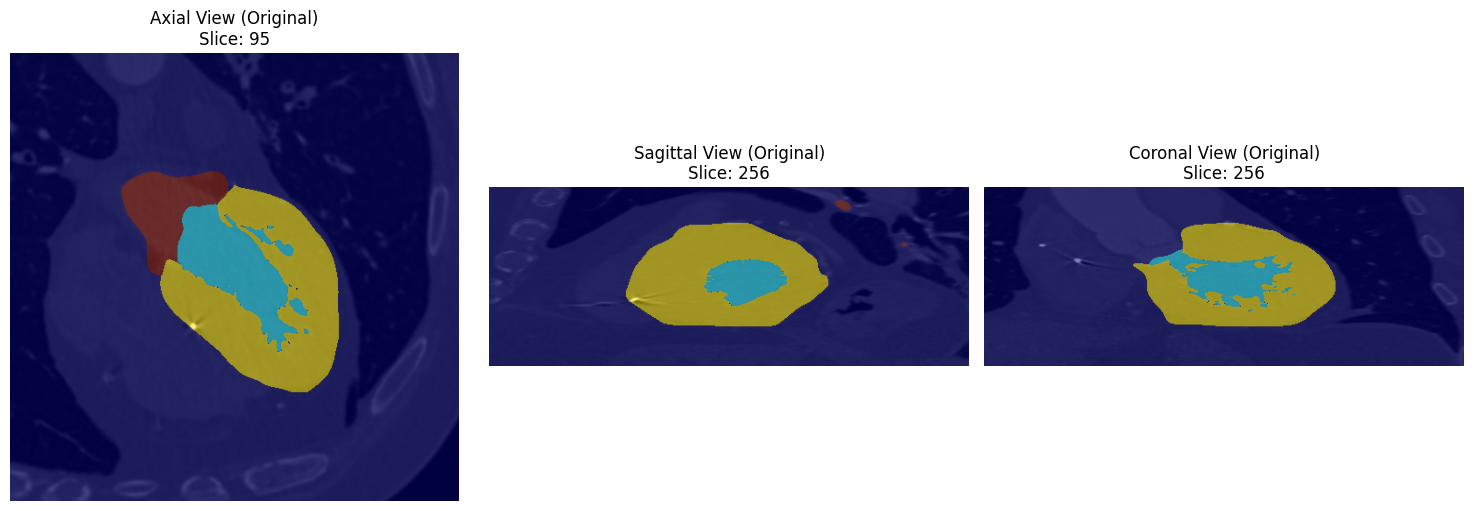

📌 Total Segmentation Volume: 351144.78 mm³
✅ Loaded: /content/drive/MyDrive/00_Diploma Thesis/Thesis_Data/Cardiac Data Greg/Swter/Patient 3/6 No series description.nrrd
✅ Loaded: /content/drive/MyDrive/00_Diploma Thesis/Thesis_Data/Cardiac Data Greg/Swter/Patient 3/Segmentation.seg.nrrd

=== Original CT Header ===
Space origin: [ -62.8105 -319.811  -285.5   ]
Space directions: [[0.37890625 0.         0.        ]
 [0.         0.37890625 0.        ]
 [0.         0.         0.7       ]]
Space: left-posterior-superior

=== Original Segmentation Header ===
Space origin: [ -62.8105 -319.811  -285.5   ]
Space directions: [[0.37890625 0.         0.        ]
 [0.         0.37890625 0.        ]
 [0.         0.         0.7       ]]
Space: left-posterior-superior
💾 Saved cropped data to:
/content/drive/MyDrive/00_Diploma Thesis/Cropped_Data/Cropped_Segmentation.nrrd
/content/drive/MyDrive/00_Diploma Thesis/Cropped_Data/Cropped_CT.nrrd


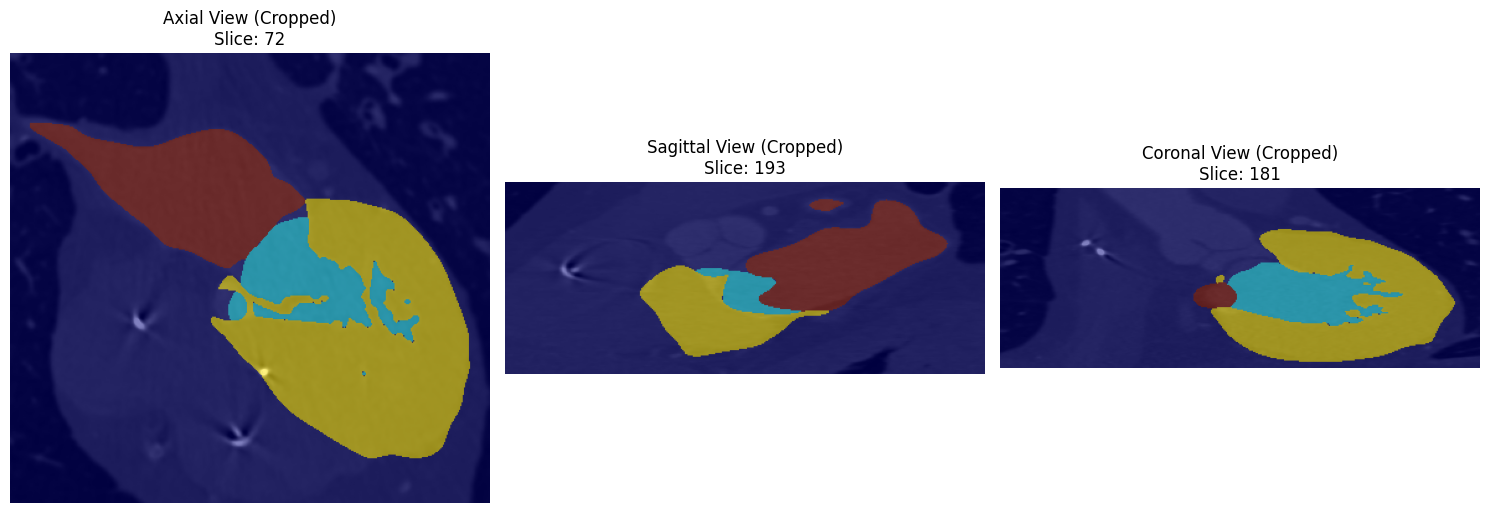

In [5]:

import nrrd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import label, find_objects

# ========== Configuration ==========
PATIENT_ID = 3
BASE_PATH = "/content/drive/MyDrive/00_Diploma Thesis/Thesis_Data/Cardiac Data Greg/Swter"
CROPPED_DATA_DIR = "/content/drive/MyDrive/00_Diploma Thesis/Cropped_Data"

# ========== Helper Functions ==========
def load_nrrd(file_path):
    """Load NRRD file and return data with header"""
    data, header = nrrd.read(file_path)
    print(f"✅ Loaded: {file_path}")
    return data, header

def plot_orthogonal_views(ct_data, seg_data, title_suffix=""):
    """Plot orthogonal views with segmentation overlay"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Axial (Z-axis)
    slice_idx = ct_data.shape[2] // 2
    axes[0].imshow(ct_data[:, :, slice_idx].T, cmap='gray', origin='lower')
    axes[0].imshow(seg_data[:, :, slice_idx].T, cmap='jet', alpha=0.5, origin='lower')
    axes[0].set_title(f"Axial View {title_suffix}\nSlice: {slice_idx}")

    # Sagittal (X-axis)
    slice_idx = ct_data.shape[0] // 2
    axes[1].imshow(ct_data[slice_idx, :, :].T, cmap='gray', origin='lower')
    axes[1].imshow(seg_data[slice_idx, :, :].T, cmap='jet', alpha=0.5, origin='lower')
    axes[1].set_title(f"Sagittal View {title_suffix}\nSlice: {slice_idx}")

    # Coronal (Y-axis)
    slice_idx = ct_data.shape[1] // 2
    axes[2].imshow(ct_data[:, slice_idx, :].T, cmap='gray', origin='lower')
    axes[2].imshow(seg_data[:, slice_idx, :].T, cmap='jet', alpha=0.5, origin='lower')
    axes[2].set_title(f"Coronal View {title_suffix}\nSlice: {slice_idx}")

    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# ========== Main Processing ==========
def main():
    # File paths
    patient_path = os.path.join(BASE_PATH, f"Patient {PATIENT_ID}")
    ct_path = os.path.join(patient_path, "6 No series description.nrrd")
    seg_path = os.path.join(patient_path, "Segmentation.seg.nrrd")

    # Load data
    ct_scan, ct_header = load_nrrd(ct_path)
    segmentation, seg_header = load_nrrd(seg_path)

    # Verify dimensions
    if ct_scan.shape != segmentation.shape:
        raise ValueError("CT and segmentation dimensions mismatch!")

    # Plot original views
    plot_orthogonal_views(ct_scan, segmentation, "(Original)")

    # Calculate volume
    if "space directions" in seg_header:
        spacing = np.abs(np.diag(seg_header["space directions"]))
    else:
        spacing = np.array([1.0, 1.0, 1.0])

    voxel_volume = np.prod(spacing)
    total_volume = np.sum(segmentation > 0) * voxel_volume
    print(f"📌 Total Segmentation Volume: {total_volume:.2f} mm³")
      # Load data
    ct_scan, ct_header = load_nrrd(ct_path)
    segmentation, seg_header = load_nrrd(seg_path)


    print("\n=== Original CT Header ===")
    print("Space origin:", ct_header.get("space origin", "Not found"))
    print("Space directions:", ct_header.get("space directions", "Not found"))
    print("Space:", ct_header.get("space", "Not found"))

    print("\n=== Original Segmentation Header ===")
    print("Space origin:", seg_header.get("space origin", "Not found"))
    print("Space directions:", seg_header.get("space directions", "Not found"))
    print("Space:", seg_header.get("space", "Not found"))

    # Crop to ROI with padding
    nonzero = np.where(segmentation > 0)
    padding = 5  # voxels

    bbox = (
        max(np.min(nonzero[0]) - padding, 0),
        min(np.max(nonzero[0]) + padding, segmentation.shape[0]),
        max(np.min(nonzero[1]) - padding, 0),
        min(np.max(nonzero[1]) + padding, segmentation.shape[1]),
        max(np.min(nonzero[2]) - padding, 0),
        min(np.max(nonzero[2]) + padding, segmentation.shape[2]),
    )

    cropped_ct = ct_scan[bbox[0]:bbox[1], bbox[2]:bbox[3], bbox[4]:bbox[5]]
    cropped_seg = segmentation[bbox[0]:bbox[1], bbox[2]:bbox[3], bbox[4]:bbox[5]]

    # Convert LPS origin to RAS
    original_origin_lps = np.array(seg_header["space origin"])
    original_origin_ras = [-original_origin_lps[0], -original_origin_lps[1], original_origin_lps[2]]

    # Calculate new origin to center the volume
    size_x = cropped_ct.shape[0] * spacing[0]
    size_y = cropped_ct.shape[1] * spacing[1]
    size_z = cropped_ct.shape[2] * spacing[2]

    new_origin_ras = [
        original_origin_ras[0] + (bbox[0] * spacing[0]) - (size_x/2),
        original_origin_ras[1] + (bbox[2] * spacing[1]) - (size_y/2),
        original_origin_ras[2] + (bbox[4] * spacing[2]) - (size_z/2)
    ]

    # Update headers
    seg_header["space origin"] = new_origin_ras
    ct_header["space origin"] = new_origin_ras
    seg_header["space"] = "RAS"  # Force RAS coordinate system
    ct_header["space"] = "RAS"
    # Update headers
    if "space origin" in seg_header:
        # Convert LPS origin to RAS
        original_origin_lps = np.array(seg_header["space origin"])
        original_origin_ras = [-original_origin_lps[0], -original_origin_lps[1], original_origin_lps[2]]

        # Calculate physical dimensions of the cropped volume
        size_x = cropped_ct.shape[0] * spacing[0]
        size_y = cropped_ct.shape[1] * spacing[1]
        size_z = cropped_ct.shape[2] * spacing[2]

        # Adjust origin to center the cropped volume in RAS space
        new_origin_ras = [
            original_origin_ras[0] + (bbox[0] * spacing[0]) - (size_x/2),
            original_origin_ras[1] + (bbox[2] * spacing[1]) - (size_y/2),
            original_origin_ras[2] + (bbox[4] * spacing[2]) - (size_z/2)
        ]

        # Update headers
        seg_header["space origin"] = new_origin_ras
        ct_header["space origin"] = new_origin_ras
        seg_header["space"] = "RAS"  # Force RAS coordinate system
        ct_header["space"] = "RAS"
    # Update headers
    seg_header["space origin"] = new_origin_ras
    ct_header["space origin"] = new_origin_ras
    seg_header["space"] = "RAS"  # Force RAS coordinate system
    ct_header["space"] = "RAS"

    # Save cropped data
    os.makedirs(CROPPED_DATA_DIR, exist_ok=True)

    cropped_seg_path = os.path.join(CROPPED_DATA_DIR, "Cropped_Segmentation.nrrd")
    cropped_ct_path = os.path.join(CROPPED_DATA_DIR, "Cropped_CT.nrrd")

    nrrd.write(cropped_seg_path, cropped_seg, header=seg_header)
    nrrd.write(cropped_ct_path, cropped_ct, header=ct_header)

    print(f"💾 Saved cropped data to:\n{cropped_seg_path}\n{cropped_ct_path}")

    # Plot cropped views
    plot_orthogonal_views(cropped_ct, cropped_seg, "(Cropped)")

if __name__ == "__main__":
    main()